# Training Data EDA

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import _pickle
import os
import glob

## Sentiment

***BBC1000***

In [2]:
# importing and creating label for bbc sentiment dataset - not used in analysis

bbc1000 = pd.read_csv('../data/train_data/sentiment/6_human_coded_datasets_good/bbc1000.txt', delimiter = '\t')
bbc1000.head(2)

,mean pos,mean neg,Comment (All)
0,1,3,Where were the suicide pilots from? Where is B...
1,1,3,"Smoker - Mainland Britain consists of England,..."


In [3]:
bbc1000['score'] = bbc1000['mean pos'] - bbc1000['mean neg']

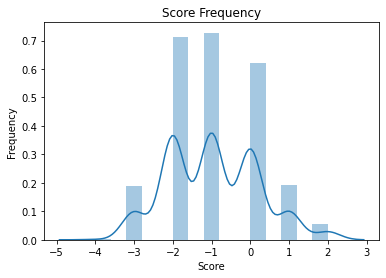

In [4]:
# checking label distribution

sns.distplot(bbc1000['score'])
plt.title('Score Frequency')
plt.xlabel('Score')
plt.ylabel('Frequency');

In [5]:
# selecting relevant columns and exporting 

bbc_formatted = bbc1000[['Comment (All)', 'score']]

In [6]:
bbc_formatted.to_csv('../data/train_data/sentiment/6_human_coded_datasets_good/bbc_formatted.csv', index = False)

***Labeled News Articles***

In [7]:
# importing labelled news articles - not used in analysis

news_raw = pd.read_csv('../data/train_data/sentiment/news_articles/news_sentiment_urls.txt', delimiter = ';')
news_raw.head(3)

,article_id,user_id,overall sentiment in %,urls
0,2,1,100.0,http://rightwingnews.com/hillary-clinton-2/bre...
1,2,2,80.0,http://rightwingnews.com/hillary-clinton-2/bre...
2,2,3,57.0,http://rightwingnews.com/hillary-clinton-2/bre...


In [8]:
news_raw[['article_id', 'urls']].groupby(['article_id', 'urls']).sum()[:20]

,
article_id,urls
2,http://rightwingnews.com/hillary-clinton-2/breaking-steps-force-fbi-director-comey-resign-process-hearing-decides-fate-sept-28/
3,http://politi.co/2cKqILg
4,http://rightwingnews.com/top-news/charlotte-police-reveal-said-black-man-just-moments-shooting/
5,http://politi.co/2d1xPwp
6,http://politi.co/2d2EDuM
7,http://conservativetribune.com/lester-holt-lies-during-debate/?utm_source=Facebook&utm_medium=RightWingNews&utm_content=2016-09-27&utm_campaign=manualpost
8,http://occupydemocrats.com/2016/09/23/just-newsweek-accuses-trump-committing-felony/
9,http://occupydemocrats.com/2016/09/28/trump-said-not-paying-taxes-makes-smart-mark-cubans-response-powerful/
10,http://viraldevil.com/police-find-19-white-female-bodies-in-freezers-with-black-lives-matter-carved-into-skin/


In [9]:
# I manually copied and pasted 50 texts from these URL's into txt documents
# and decided the data was not very good during model building 
# did not grab other ~200 articles

texts = []

path = '../data/train_data/sentiment/news_articles/articles/'
i=1
for filename in glob.glob(os.path.join(path, '*.txt')):
   with open(filename, 'r', encoding='utf-8') as f:
    texts.append([filename[52:-4], f.read()])

In [10]:
# formatting text data

texts = pd.DataFrame(texts)

In [11]:
texts[0] = texts[0].astype(int)

In [12]:
texts = texts.sort_values(0)[:49].reset_index().drop(columns = 'index')

In [13]:
texts.rename(columns = {0 : 'id', 1 : 'text'}, inplace = True)

In [14]:
texts['text'] = texts['text'].replace('N/A', np.nan)

In [15]:
texts.dropna(inplace = True)

In [16]:
texts.head(2)

,id,text
0,2,The FBI investigation of the Hillary Clinton e...
1,3,At least 858 people who had previously been or...


In [17]:
# merging texts with original dataframe

news = news_raw.merge(texts, left_on = 'article_id', right_on = 'id')

In [18]:
# getting average user score by article and appending to df

keys_news = pd.Series(news.groupby('text')['overall sentiment in %'].agg('mean').keys())
values_news = pd.Series(news.groupby('text')['overall sentiment in %'].agg('mean').values)

In [19]:
average_scores = pd.concat([keys_news, values_news], axis = 1).rename(columns = {0 : 'average'})

In [20]:
news_formatted = news.merge(average_scores, on = 'text')[['text', 'average']].drop_duplicates()

In [21]:
news_formatted.head(2)

,text,average
0,The FBI investigation of the Hillary Clinton e...,70.000000
20,At least 858 people who had previously been or...,17.578947


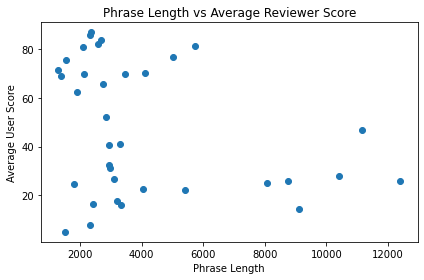

In [22]:
# seeing if there is a relationship between text length and score

plt.scatter([len(x) for x in news_formatted['text']], news_formatted['average'])
plt.xlabel('Phrase Length')
plt.ylabel('Average User Score')
plt.title('Phrase Length vs Average Reviewer Score')
plt.tight_layout();

In [23]:
# exporting formatted data

news_formatted.to_csv('../data/train_data/sentiment/news_articles/news_formatted.csv', index = False)

***IMDB***

In [24]:
# importing IMDB reviews - each review is individual file - not used in analysis

pos_reviews = []

path_pos = '../data/train_data/sentiment/IMDB_good/pos/'
for filename in glob.glob(os.path.join(path_pos, '*.txt')):
   with open(filename, 'r') as f:
    pos_reviews.append(f.read())

In [25]:
len(pos_reviews)

1000

In [26]:
neg_reviews = []

path_neg = '../data/train_data/sentiment/IMDB_good/neg/'
for filename in glob.glob(os.path.join(path_neg, '*.txt')):
   with open(filename, 'r') as f:
    neg_reviews.append(f.read())

In [27]:
len(neg_reviews)

1000

In [28]:
# renaming review columns and merging pos/neg reviews to one df, creating is_positive column

pos_reviews = pd.DataFrame(pos_reviews).rename(columns = {0 : 'text'})
neg_reviews = pd.DataFrame(neg_reviews).rename(columns = {0 : 'text'})

In [29]:
pos_reviews['is_positive'] = [1]*len(pos_reviews['text'])
neg_reviews['is_positive'] = [0]*len(neg_reviews['text'])

In [30]:
pos_neg_reviews = pd.concat([pos_reviews, neg_reviews])

In [31]:
pos_neg_reviews.head(2)

,text,is_positive
0,films adapted from comic books have had plenty...,1
1,every now and then a movie comes along from a ...,1


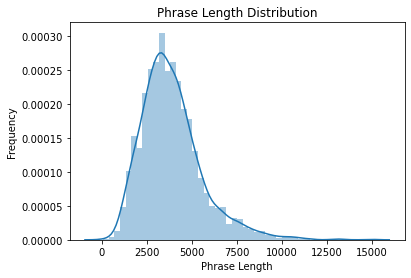

In [32]:
sns.distplot([len(x) for x in pos_neg_reviews['text']])
plt.title('Phrase Length Distribution')
plt.xlabel('Phrase Length')
plt.ylabel('Frequency');

In [33]:
# exporting to csv

pos_neg_reviews.to_csv('../data/train_data/sentiment/IMDB_good/imdb_formatted.csv', index = False)

***UCI Combined***

In [34]:
# importing/combining UCI labelled datasets - ARE using in analysis

uci_amazon = pd.read_csv('../data/train_data/sentiment/UCI/amazon_cells_labelled.txt', delimiter = '\t', header = None)
uci_imdb = pd.read_csv('../data/train_data/sentiment/UCI/imdb_labelled.txt', delimiter = '\t', header = None)
uci_yelp = pd.read_csv('../data/train_data/sentiment/UCI/yelp_labelled.txt', delimiter = '\t', header = None)

In [35]:
uci_combined = pd.concat([uci_amazon, uci_imdb, uci_yelp], axis = 0)
uci_combined.rename(columns = {0 : 'text', 1 : 'is_positive'}, inplace = True)

uci_combined.head(3)

,text,is_positive
0,So there is no way for me to plug it in here i...,0
1,"Good case, Excellent value.",1
2,Great for the jawbone.,1


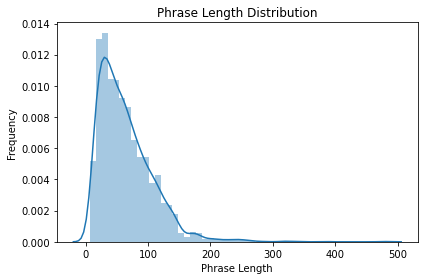

In [36]:
sns.distplot([len(x) for x in uci_combined['text'] if len(x) < 500])
plt.xlabel('Phrase Length')
plt.ylabel('Frequency')
plt.title('Phrase Length Distribution')
plt.tight_layout();

In [37]:
uci_combined['is_positive'].value_counts(normalize = True)

1    0.504367
0    0.495633
Name: is_positive, dtype: float64

In [38]:
# Exporting to csv

uci_combined.to_csv('../data/train_data/sentiment/UCI/uci_combined.csv', index = False)

## Ideological - Not used in analysis

In [39]:
# module provided by IBC data owner below - modified one print statement to fit python syntax

import treeUtil

In [40]:
# This whole script was provided by dataset owner Mohit Iyyer


[lib, con, neutral] = _pickle.load(open('../data/train_data/ideology/IBC/ibcData.pkl', 'rb'))

print(f'Liberal examples (out of {len(lib)} sentences): ')
for tree in lib[0:1]:
    print(tree.get_words())

print(f'\nConservative examples (out of {len(con)} sentences): ')
for tree in con[0:1]:
    print(tree.get_words())

print(f'\nNeutral examples (out of {len(neutral)} sentences): ')
for tree in neutral[0:1]:
    print(tree.get_words())

# how to access phrase labels for a particular tree
ex_tree = lib[0]

print('\nPhrase labels for one tree: ')

# see treeUtil.py for the tree class definition
for node in ex_tree:

    # remember, only certain nodes have labels (see paper for details)
    if hasattr(node, 'label'):
        print(node.label, ': ', node.get_words())

Liberal examples (out of 2025 sentences): 
Forcing middle-class workers to bear a greater share of the cost of government weakens their support for needed investments and stirs resentment toward those who depend on public services the most .

Conservative examples (out of 1701 sentences): 
Gore is getting rich from environmentalism , not just by being paid a whopping $ 175,000 per speech but by using political pressure to force government policy in a direction that benefits his business interests .

Neutral examples (out of 600 sentences): 
In this country , the beneficiaries of Apple 's success are , first , the designers , who have done wonders working with Steve Jobs to produce products that are beautiful and effective .

Phrase labels for one tree: 
Liberal :  Forcing middle-class workers to bear a greater share of the cost of government weakens their support for needed investments and stirs resentment toward those who depend on public services the most .
Liberal :  weakens their s

In [41]:
# creating df's for each category and merging into single df

liberal = []
conservative = []
neutral_phrases = []

for phrase in lib:
    liberal.append(phrase.get_words())
    
for phrase in con:
    conservative.append(phrase.get_words())
    
for phrase in neutral:
    neutral_phrases.append(phrase.get_words())    

In [42]:
liberal = pd.DataFrame(liberal)
liberal['is_liberal'] = [1]*len(liberal[0])
liberal.rename(columns = {0 : 'text'}, inplace = True)

conservative = pd.DataFrame(conservative)
conservative['is_liberal'] = [-1]*len(conservative[0])
conservative.rename(columns = {0 : 'text'}, inplace = True)

neutral_phrases = pd.DataFrame(neutral_phrases)
neutral_phrases['is_liberal'] = [0]*len(neutral_phrases[0])
neutral_phrases.rename(columns = {0 : 'text'}, inplace = True)

In [43]:
ideological = pd.concat([liberal, conservative, neutral_phrases], axis = 0)

In [44]:
ideological['is_liberal'].value_counts()

 1    2025
-1    1701
 0     600
Name: is_liberal, dtype: int64

In [45]:
# exporting to CSV

ideological.to_csv('../data/train_data/ideology/IBC/ideological_formatted.csv', index = False)

## Subjectivity Analysis

In [46]:
# importing, renaming, labeling, and combining subj/obj datasets

subjective = pd.read_csv('../data/train_data/subjectivity/subjective.txt', delimiter = '\n', encoding = "ISO-8859-1", header = None) 
objective = pd.read_csv('../data/train_data/subjectivity/objective.txt', delimiter = '\n', encoding = "ISO-8859-1", header = None) 

In [47]:
print(subjective.head(), objective.head())

                                                   0
0  smart and alert , thirteen conversations about...
1  color , musical bounce and warm seas lapping o...
2  it is not a mass-market entertainment but an u...
3  a light-hearted french film about the spiritua...
4  my wife is an actress has its moments in looki...                                                    0
0  the movie begins in the past where a young boy...
1  emerging from the human psyche and showing cha...
2  spurning her mother's insistence that she get ...
3  amitabh can't believe the board of directors a...
4  she , among others excentricities , talks to a...


In [48]:
subjective.rename(columns = {0 : 'text'}, inplace = True)
objective.rename(columns = {0 : 'text'}, inplace = True)

In [49]:
print(subjective.shape)
print(objective.shape)

(5000, 1)
(5000, 1)


In [50]:
subjective['is_subjective'] = [1]*subjective.shape[0]
objective['is_subjective'] = [0]*subjective.shape[0]

In [51]:
print(subjective.head(), objective.head())

                                                text  is_subjective
0  smart and alert , thirteen conversations about...              1
1  color , musical bounce and warm seas lapping o...              1
2  it is not a mass-market entertainment but an u...              1
3  a light-hearted french film about the spiritua...              1
4  my wife is an actress has its moments in looki...              1                                                 text  is_subjective
0  the movie begins in the past where a young boy...              0
1  emerging from the human psyche and showing cha...              0
2  spurning her mother's insistence that she get ...              0
3  amitabh can't believe the board of directors a...              0
4  she , among others excentricities , talks to a...              0


In [52]:
subj_obj = pd.concat([subjective, objective])

In [53]:
subj_obj['is_subjective'].value_counts()

1    5000
0    5000
Name: is_subjective, dtype: int64

In [54]:
subj_obj.head()

,text,is_subjective
0,"smart and alert , thirteen conversations about...",1
1,"color , musical bounce and warm seas lapping o...",1
2,it is not a mass-market entertainment but an u...,1
3,a light-hearted french film about the spiritua...,1
4,my wife is an actress has its moments in looki...,1


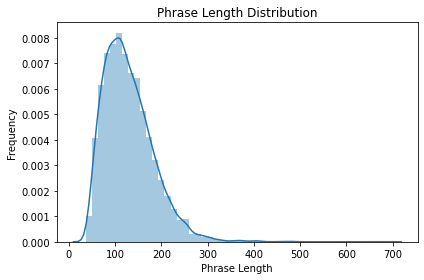

In [55]:
sns.distplot([len(x) for x in subj_obj['text']])
plt.xlabel('Phrase Length')
plt.ylabel('Frequency')
plt.title('Phrase Length Distribution')
plt.tight_layout();

In [56]:
# exporting to CSV

subj_obj.to_csv('../data/train_data/subjectivity/subj_obj_formatted.csv', index = False)